# Algorithmic Trading Model for Mean-Reversion with RSI Exit Signal for an Individual Stock Using Python
### David Lowe
### July 21, 2021

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This algorithmic trading model compares a simple mean-reversion strategy with or without using RSI as the exit signal for an individual stock. The model will use a trend window size of ten days for long trades only. When the 14-day RSI value reaches 70, the model will exit the long position.

ANALYSIS: In this modeling iteration, we analyzed the stock of AAPL (Apple Inc.) between January 1, 2016, and July 19, 2021. The mean-reversion model without using RSI produced a profit of 3.59 dollars per share, while the model with RSI signals returned 45.97. In addition, the buy-and-hold approach yielded a gain of 118.09 dollars per share.

CONCLUSION: For the AAPL stock during the modeling time frame, the long-only trading strategy with or without RSI as the exit signal did not produce a better return than the buy-and-hold approach. We should consider experimenting with more variations of the strategy.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Implement and Train Models
4. Back-test Models
5. Evaluate Strategy Performance

## Task 1 - Prepare Environment

### 1.a) Load libraries and modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats
import os
import sys
from datetime import date, datetime, timedelta
import requests
import json
from dotenv import load_dotenv

# Begin the timer for the script processing
startTimeScript = datetime.now()

### 1.b) Set up the controlling parameters and functions¶

In [2]:
# Specify the key modeling parameters below
stock_list = ['AAPL']

# Specify the parameters for calculating moving average windows
TREND_WINDOW = 10
VOLUME_WINDOW = 10
MEAN_REVERSION = True  # If false, model using the trend-following strategy

# Specify the parameters for calculating RSI
RSI_WINDOW = 14
RSI_HIGH = 70
RSI_MIDDLE = 50
RSI_LOW = 30

# Specify the risk management parameters
HOLDING_PERIOD_MIN = 999
HOLDING_PERIOD_MAX = 999
GAIN_MAX = 0.99
LOSS_MAX = 0.99
LONG_ONLY = True  # If false, model both long and short trades

# The number of extra days of data we need for calculating moving averages (usually equals to the largest value of window size)
EXTRA_DAYS = TREND_WINDOW

MODEL_START_DATE = date(2016, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

# MODEL_END_DATE = datetime.now().date()
MODEL_END_DATE = date(2021, 7, 19)
print("Ending date for the model:", MODEL_END_DATE)

# data_start_date = MODEL_START_DATE
data_start_date = MODEL_START_DATE - timedelta(days=int(EXTRA_DAYS * 2)) # Need more pricing data to calculate moving averages
print("First date of data we need for modeling:", data_start_date)

data_end_date = MODEL_END_DATE
print("Last date of data we need for modeling:", data_end_date)

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose_data_retrieval = False  # Show the head and tail of the raw dataframe
verbose_signals = False  # All entries from the Signals dataframe
verbose_entry_exit = False  # All entry and exit points from the Signals dataframe
verbose_trade_actions = False  # All bought and sold activities during portfolio generation
verbose_portfolios = False  # All entries from the Positions dataframe
verbose_transactions = True  #  All buying and selling transactions from the Positions dataframe
verbose_draw_graphs = True

Starting date for the model: 2016-01-01
Ending date for the model: 2021-07-19
First date of data we need for modeling: 2015-12-12
Last date of data we need for modeling: 2021-07-19


In [3]:
# Set up parameters for displaying report data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 999)

## Task 2 - Acquire and Pre-Process Data

In [4]:
def retrieve_stock_data(ticker=stock_list[0]):
    # Set up the data service provider and data acquisition parameters
    data_service = 'Quandl'

    # Check and see whether the API key is available
    api_key = os.environ.get('QUANDL_API')
    if api_key is None: sys.exit(data_service + ' API key not available. Script processing cannot continue!!!')

    if ticker=='': sys.exit('Stock symbol not available. Script processing cannot continue!!!')

    start_date_string = data_start_date.strftime('%Y-%m-%d')
    end_date_string = data_end_date.strftime('%Y-%m-%d')
    api_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s&qopts.data_version=2" % (start_date_string, end_date_string, ticker, api_key)
    response = requests.get(api_url)
    resp_dict = json.loads(response.text)
    stock_rawdata = pd.DataFrame(resp_dict['datatable']['data'])
    print(len(stock_rawdata), 'data points retrieved from the API call for stock:', ticker)

    stock_rawdata.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'closeadj', 'closeunadj', 'lastupdated']
    # stock_rawdata.set_index('date', inplace=True)
    stock_rawdata.index = pd.to_datetime(stock_rawdata.date)
    stock_pricing = stock_rawdata.sort_index(ascending=True)

    # Set up the standard column name for modeling
    # Column names may be data-provider specific!
    model_template = stock_pricing.loc[:, ['open','closeadj','volume']]
    model_template.rename(columns={'open': 'open_price', 'closeadj': 'close_price', 'volume': 'trading_volume'}, inplace=True)
    if verbose_data_retrieval:
        print(model_template.head())
        print()
        print(model_template.tail())

    return model_template

## Task 3 - Implement and Train Models

In [5]:
# Define the function that will generate the indicators and trading signals
# General logic for processing the trading signals for each time period
# 1 - Check to see whether we need to execute a trading action from the previous day's signal. Once the trading action is executed, move on to the next day.
# 2 - If no trade actions to execute on open, check to see whether we have any breakout that generates a trading signal. If we have a new trading signal and currently has no position, mark the entry action for the next day.
# 3 - If no new signal for today, check to see whether we need to exit any existing position. If we have an exit signal and currently hold a position, mark the exit action for the next day.
# 4 - If nothing is going on, mark up the trading model appropriately and move to the next day.

def populate_signals_model1(model_template):
    """Calculate signals for a Mean Reversion strategy

    Strategy details:
    Entry signals -- Low point of a trend window (default 10 days)
    Exit signals -- high point of a trend window (default 10 days)
    """

    trade_model = model_template.copy()
    mean_reversion_flag = MEAN_REVERSION
    trend_window = TREND_WINDOW
    volume_window = VOLUME_WINDOW

    trade_model['buy_on_open'] = False
    trade_model['sell_on_open'] = False
    trade_model['short_on_open'] = False
    trade_model['cover_on_open'] = False
    trade_model['position_long'] = False
    trade_model['position_short'] = False
    trade_model['holding_period'] = 0
    trade_model['cost_basis'] = 0.0
    trade_model['gain_loss_pct'] = 0.0
    trade_model['window_avg'] = trade_model['close_price'].shift(1).rolling(window=trend_window).mean()
    trade_model['window_high'] = trade_model['close_price'].shift(1).rolling(window=trend_window).max()
    trade_model['window_low'] = trade_model['close_price'].shift(1).rolling(window=trend_window).min()
    trade_model['volume_ma'] = trade_model['trading_volume'].rolling(volume_window).mean()

    # Truncate the model to the required starting and ending dates
    trade_model = trade_model[MODEL_START_DATE:MODEL_END_DATE]
    last_index = len(trade_model) - 1

    for k in range(len(trade_model)-1):
        # Calculate the breakout, True or False.
        price_today = trade_model.at[trade_model.index[k],'close_price']
        price_high =  trade_model.at[trade_model.index[k],'window_high']
        price_low = trade_model.at[trade_model.index[k],'window_low']
        if mean_reversion_flag:
            breakout_long_side = price_today < price_low
            breakout_short_side = price_today > price_high
        else:
            breakout_long_side = price_today > price_high
            breakout_short_side = price_today < price_low
        volume_today = trade_model.at[trade_model.index[k],'trading_volume']
        volume_avg = trade_model.at[trade_model.index[k],'volume_ma']

        # Set the exit signals
        price_avg = trade_model.at[trade_model.index[k],'window_avg']
        close_above_threshold = price_today > price_avg
        close_below_threshold = price_today < price_avg

        # For the very first trading session, just need to check for the breakout action
        if k == 0:
            if breakout_long_side and (volume_today > volume_avg):
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif breakout_short_side and (volume_today > volume_avg) and (not LONG_ONLY):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True
        else:
            currently_long = trade_model.at[trade_model.index[k-1],'position_long']
            currently_short = trade_model.at[trade_model.index[k-1],'position_short']
            holding_period = trade_model.at[trade_model.index[k-1],'holding_period']
            cost_basis = trade_model.at[trade_model.index[k-1],'cost_basis']

            # Check to see whether we need to execute any trade action on open
            if trade_model.at[trade_model.index[k],'buy_on_open']:
                trade_executed_today = True
                currently_long = True
                currently_short = False
                holding_period = 1
                cost_basis = -trade_model.at[trade_model.index[k],'open_price']
            elif trade_model.at[trade_model.index[k],'short_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = True
                holding_period = 1
                cost_basis = trade_model.at[trade_model.index[k],'open_price']
            elif trade_model.at[trade_model.index[k],'sell_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = False
                holding_period = 0
                cost_basis = 0.0
            elif trade_model.at[trade_model.index[k],'cover_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = False
                holding_period = 0
                cost_basis = 0.0
            else:
                trade_executed_today = False

            # If no trade on open, check to see whether we have a breakout with an entry the next day
            if breakout_long_side and (not currently_long) and (not currently_short) and (volume_today > volume_avg) and (k < last_index):
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif breakout_short_side and (not currently_long) and (not currently_short) and (volume_today > volume_avg) and (k < last_index) and (not LONG_ONLY):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True

            # If no breakout, check to see whether we need to exit based on the price action
            if currently_long and ((mean_reversion_flag and close_above_threshold) or ((not mean_reversion_flag) and close_below_threshold) or (holding_period >= HOLDING_PERIOD_MAX)):
                trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            elif currently_short and ((mean_reversion_flag and close_below_threshold) or ((not mean_reversion_flag) and close_above_threshold) or (holding_period >= HOLDING_PERIOD_MAX)):
                trade_model.at[trade_model.index[k+1],'cover_on_open'] = True

            # If no breakout, check to see whether we need to exit based on the profit or loss targets
            if currently_long :
                up_down_pct = (cost_basis + price_today) / abs(cost_basis)
                trade_model.at[trade_model.index[k],'gain_loss_pct'] = up_down_pct
                if (up_down_pct >= GAIN_MAX) or (up_down_pct <= -LOSS_MAX) :
                    trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            elif currently_short :
                up_down_pct = (cost_basis - price_today) / abs(cost_basis)
                trade_model.at[trade_model.index[k],'gain_loss_pct'] = up_down_pct
                if (up_down_pct >= GAIN_MAX) or (up_down_pct <= -LOSS_MAX) :
                    trade_model.at[trade_model.index[k+1],'cover_on_open'] = True

            # If no action on a given day, carry over the position status
            if (k > 0) and (not trade_executed_today):
                if currently_long or currently_short:
                    holding_period = holding_period + 1

            trade_model.at[trade_model.index[k],'position_long'] = currently_long
            trade_model.at[trade_model.index[k],'position_short'] = currently_short
            trade_model.at[trade_model.index[k],'holding_period'] = holding_period
            trade_model.at[trade_model.index[k],'cost_basis'] = cost_basis

            # # Exiting the position on the last day of modeling period
            # if k == last_index-1:
            #     if trade_model.at[trade_model.index[k],'position_long']:
            #         trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            #         trade_model.at[trade_model.index[k+1],'position_long'] = False
            #     elif trade_model.at[trade_model.index[k],'position_short']:
            #         trade_model.at[trade_model.index[k+1],'cover_on_open'] = True
            #         trade_model.at[trade_model.index[k+1],'position_short'] = False

    if verbose_signals: print(trade_model, '\n')
    return trade_model

In [6]:
# Define the function that will generate the indicators and trading signals
# General logic for processing the trading signals for each time period
# 1 - Check to see whether we need to execute a trading action from the previous day's signal. Once the trading action is executed, move on to the next day.
# 2 - If no trade actions to execute on open, check to see whether we have any breakout that generates a trading signal. If we have a new trading signal and currently has no position, mark the entry action for the next day.
# 3 - If no new signal for today, check to see whether we need to exit any existing position. If we have an exit signal and currently hold a position, mark the exit action for the next day.
# 4 - If nothing is going on, mark up the trading model appropriately and move to the next day.

def populate_signals_model2(model_template):
    """Calculate signals for a Mean Reversion strategy

    Strategy details:
    Entry signals -- Low point of a trend window (default 10 days)
    Exit signals -- Above the high RSI threshold (default 70)
    """

    trade_model = model_template.copy()
    mean_reversion_flag = MEAN_REVERSION
    trend_window = TREND_WINDOW
    volume_window = VOLUME_WINDOW
    rsi_lookback = RSI_WINDOW

    trade_model['buy_on_open'] = False
    trade_model['sell_on_open'] = False
    trade_model['short_on_open'] = False
    trade_model['cover_on_open'] = False
    trade_model['position_long'] = False
    trade_model['position_short'] = False
    trade_model['holding_period'] = 0
    trade_model['cost_basis'] = 0.0
    trade_model['gain_loss_pct'] = 0.0
    trade_model['window_avg'] = trade_model['close_price'].shift(1).rolling(window=trend_window).mean()
    trade_model['window_high'] = trade_model['close_price'].shift(1).rolling(window=trend_window).max()
    trade_model['window_low'] = trade_model['close_price'].shift(1).rolling(window=trend_window).min()
    trade_model['volume_ma'] = trade_model['trading_volume'].rolling(volume_window).mean()

    # Calculate the RSI ratings
    gain_history = []
    loss_history = []
    for k in range(len(trade_model)):
        close_price = trade_model.at[trade_model.index[k],'close_price']
        if k == 0:
            trade_model.at[trade_model.index[k],'rsi_value'] = 50
        else:
            previous_price = trade_model.at[trade_model.index[k-1],'close_price']
            gain_history.append(max(0, close_price - previous_price))
            loss_history.append(max(0, previous_price - close_price))
            if len(gain_history) > rsi_lookback: # maximum observations is equal to look-back period
                del (gain_history[0])
                del (loss_history[0])
            avg_gain = stats.mean(gain_history) # average gain over look-back period
            avg_loss = stats.mean(loss_history) # average loss over look-back period
            rs = 1
            if avg_loss > 0: # to avoid division by 0, which is undefined
                rs = avg_gain / avg_loss
            trade_model.at[trade_model.index[k],'rsi_value'] = 100 - (100 / (1 + rs))

    # Truncate the model to the required starting and ending dates
    trade_model = trade_model[MODEL_START_DATE:MODEL_END_DATE]
    last_index = len(trade_model) - 1

    for k in range(len(trade_model)-1):
        # Calculate the breakout, True or False.
        price_today = trade_model.at[trade_model.index[k],'close_price']
        price_high =  trade_model.at[trade_model.index[k],'window_high']
        price_low = trade_model.at[trade_model.index[k],'window_low']
        if mean_reversion_flag:
            breakout_long_side = price_today < price_low
            breakout_short_side = price_today > price_high
        else:
            breakout_long_side = price_today > price_high
            breakout_short_side = price_today < price_low
        volume_today = trade_model.at[trade_model.index[k],'trading_volume']
        volume_avg = trade_model.at[trade_model.index[k],'volume_ma']

        # Set the exit signals
        rsi_value = trade_model.at[trade_model.index[k],'rsi_value']
        close_above_threshold = rsi_value > RSI_HIGH
        close_below_threshold = rsi_value < RSI_LOW

        # For the very first trading session, just need to check for the breakout action
        if k == 0:
            if breakout_long_side and (volume_today > volume_avg):
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif breakout_short_side and (volume_today > volume_avg) and (not LONG_ONLY):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True
        else:
            currently_long = trade_model.at[trade_model.index[k-1],'position_long']
            currently_short = trade_model.at[trade_model.index[k-1],'position_short']
            holding_period = trade_model.at[trade_model.index[k-1],'holding_period']
            cost_basis = trade_model.at[trade_model.index[k-1],'cost_basis']

            # Check to see whether we need to execute any trade action on open
            if trade_model.at[trade_model.index[k],'buy_on_open']:
                trade_executed_today = True
                currently_long = True
                currently_short = False
                holding_period = 1
                cost_basis = -trade_model.at[trade_model.index[k],'open_price']
            elif trade_model.at[trade_model.index[k],'short_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = True
                holding_period = 1
                cost_basis = trade_model.at[trade_model.index[k],'open_price']
            elif trade_model.at[trade_model.index[k],'sell_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = False
                holding_period = 0
                cost_basis = 0.0
            elif trade_model.at[trade_model.index[k],'cover_on_open']:
                trade_executed_today = True
                currently_long = False
                currently_short = False
                holding_period = 0
                cost_basis = 0.0
            else:
                trade_executed_today = False

            # If no trade on open, check to see whether we have a breakout with an entry the next day
            if breakout_long_side and (not currently_long) and (not currently_short) and (volume_today > volume_avg) and (k < last_index):
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif breakout_short_side and (not currently_long) and (not currently_short) and (volume_today > volume_avg) and (k < last_index) and (not LONG_ONLY):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True

            # If no breakout, check to see whether we need to exit based on the price action
            if currently_long and ((mean_reversion_flag and close_above_threshold) or ((not mean_reversion_flag) and close_below_threshold) or (holding_period >= HOLDING_PERIOD_MAX)):
                trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            elif currently_short and ((mean_reversion_flag and close_below_threshold) or ((not mean_reversion_flag) and close_above_threshold) or (holding_period >= HOLDING_PERIOD_MAX)):
                trade_model.at[trade_model.index[k+1],'cover_on_open'] = True

            # If no breakout, check to see whether we need to exit based on the profit or loss targets
            if currently_long :
                up_down_pct = (cost_basis + price_today) / abs(cost_basis)
                trade_model.at[trade_model.index[k],'gain_loss_pct'] = up_down_pct
                if (up_down_pct >= GAIN_MAX) or (up_down_pct <= -LOSS_MAX) :
                    trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            elif currently_short :
                up_down_pct = (cost_basis - price_today) / abs(cost_basis)
                trade_model.at[trade_model.index[k],'gain_loss_pct'] = up_down_pct
                if (up_down_pct >= GAIN_MAX) or (up_down_pct <= -LOSS_MAX) :
                    trade_model.at[trade_model.index[k+1],'cover_on_open'] = True

            # If no action on a given day, carry over the position status
            if (k > 0) and (not trade_executed_today):
                if currently_long or currently_short:
                    holding_period = holding_period + 1

            trade_model.at[trade_model.index[k],'position_long'] = currently_long
            trade_model.at[trade_model.index[k],'position_short'] = currently_short
            trade_model.at[trade_model.index[k],'holding_period'] = holding_period
            trade_model.at[trade_model.index[k],'cost_basis'] = cost_basis

            # # Exiting the position on the last day of modeling period
            # if k == last_index-1:
            #     if trade_model.at[trade_model.index[k],'position_long']:
            #         trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
            #         trade_model.at[trade_model.index[k+1],'position_long'] = False
            #     elif trade_model.at[trade_model.index[k],'position_short']:
            #         trade_model.at[trade_model.index[k+1],'cover_on_open'] = True
            #         trade_model.at[trade_model.index[k+1],'position_short'] = False

    if verbose_signals: print(trade_model, '\n')
    return trade_model

In [7]:
# List the entry/exit points for each model
def list_model_entry_exit(trade_model):
    print(trade_model[trade_model['buy_on_open'] | trade_model['sell_on_open'] | trade_model['short_on_open'] | trade_model['cover_on_open']])

In [8]:
def draw_model_graph(trade_model, ticker='', model_name=''):
    graph_data = trade_model.copy()
    title_string = model_name + ' Trading Model for ' + ticker
    fig = plt.figure(figsize=(16,9))
    ylabel = ticker + ' price in $'
    ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
    graph_data['close_price'].plot(ax=ax1, color='g')
    graph_data['window_high'].plot(ax=ax1, color='b')
    graph_data['window_low'].plot(ax=ax1, color='r')
    ax1.plot(graph_data.loc[graph_data['buy_on_open']].index, graph_data.close_price[graph_data['buy_on_open']], '^', markersize=7, color='b',label='Buy on Open')
    ax1.plot(graph_data.loc[graph_data['sell_on_open']].index, graph_data.close_price[graph_data['sell_on_open']], 'v', markersize=7, color='b',label='Sell on Open')
    ax1.plot(graph_data.loc[graph_data['short_on_open']].index, graph_data.close_price[graph_data['short_on_open']], '^', markersize=7, color='r',label='Short on Open')
    ax1.plot(graph_data.loc[graph_data['cover_on_open']].index, graph_data.close_price[graph_data['cover_on_open']], 'v', markersize=7, color='r',label='Cover on Open')
    plt.legend(loc='upper left')
    plt.show()

## Task 4 - Back-test Models

In [9]:
def generate_trading_portfolios(trade_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trade_model.index, columns=['trade_action', 'price_executed', 'qty_transacted', 'cost_basis', 'gain_loss', 'qty_on_hand', 'cash_on_hand', 'position_value', 'total_position', 'accum_return'])
    portfolio['trade_action'] = False
    portfolio.at[portfolio.index[0],'price_executed'] = 0.00
    portfolio.at[portfolio.index[0],'qty_transacted'] = 0
    portfolio.at[portfolio.index[0],'cost_basis'] = 0.00
    portfolio.at[portfolio.index[0],'gain_loss'] = 0.00
    portfolio.at[portfolio.index[0],'qty_on_hand'] = 0
    portfolio.at[portfolio.index[0],'cash_on_hand'] = INITIAL_CAPITAL
    portfolio.at[portfolio.index[0],'position_value'] = 0.00
    portfolio.at[portfolio.index[0],'total_position'] = INITIAL_CAPITAL
    portfolio.at[portfolio.index[0],'accum_return'] = 0.00
    quantity = 1

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        price_per_share = trade_model.at[trade_model.index[i],'open_price']
        if trade_model.at[trade_model.index[i],'buy_on_open']:
            # Code block for Buy on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = quantity
            recent_cost = price_per_share * -quantity
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] + quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + recent_cost
            if verbose_trade_actions: print('BOUGHT QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', price_per_share)
        elif trade_model.at[trade_model.index[i],'sell_on_open']:
            # Code block for Sell on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = -quantity
            recent_cost = 0.00
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = (price_per_share * quantity) + portfolio.iloc[i-1]['cost_basis']
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] - quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + (price_per_share * quantity)
            if verbose_trade_actions: print('SOLD QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', price_per_share)
        elif trade_model.at[trade_model.index[i],'short_on_open']:
            # Code block for Short on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = -quantity
            recent_cost = price_per_share * quantity
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] - quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + recent_cost
            if verbose_trade_actions: print('SHORTED QTY:', -quantity, 'on', portfolio.index[i].date(), 'at the price of', trade_model.at[portfolio.index[i],'open_price'])
        elif trade_model.at[trade_model.index[i],'cover_on_open']:
            # Code block for Cover on Open
            portfolio.at[portfolio.index[i],'trade_action'] = True
            portfolio.at[portfolio.index[i],'price_executed'] = price_per_share
            portfolio.at[portfolio.index[i],'qty_transacted'] = quantity
            recent_cost = 0.00
            portfolio.at[portfolio.index[i],'cost_basis'] = recent_cost
            portfolio.at[portfolio.index[i],'gain_loss'] = portfolio.iloc[i-1]['cost_basis'] - (price_per_share * quantity)
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] + quantity
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] - (price_per_share * quantity)
            if verbose_trade_actions: print('COVERED QTY:', quantity, 'on', portfolio.index[i].date(), 'at the price of', trade_model.at[portfolio.index[i],'open_price'])
        else:
            # Code block for no trade actions
            portfolio.at[portfolio.index[i],'price_executed'] = 0.00
            portfolio.at[portfolio.index[i],'qty_transacted'] = 0
            portfolio.at[portfolio.index[i],'cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.at[portfolio.index[i],'gain_loss'] = 0.00
            portfolio.at[portfolio.index[i],'qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand']
            portfolio.at[portfolio.index[i],'cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand']
        portfolio.at[portfolio.index[i],'position_value'] = trade_model.at[trade_model.index[i],'close_price'] * portfolio.at[portfolio.index[i],'qty_on_hand']
        portfolio.at[portfolio.index[i],'total_position'] = portfolio.at[portfolio.index[i],'cash_on_hand'] + portfolio.at[portfolio.index[i],'position_value']
        portfolio.at[portfolio.index[i],'accum_return'] = portfolio.at[portfolio.index[i],'total_position'] - INITIAL_CAPITAL

    if verbose_portfolios: print('\n', portfolio, '\n')
    return portfolio

In [10]:
def calculate_positions_performance(trade_model):
    trade_positions = generate_trading_portfolios(trade_model)
    trade_transactions = trade_positions[trade_positions['trade_action']]
    if verbose_transactions: print(trade_transactions)
    if trade_transactions.at[trade_transactions.index[-1],'trade_action']:
        if trade_transactions.at[trade_transactions.index[-1],'qty_on_hand'] == 0:
            print('The current status of the model is:','Waiting to enter a position since',trade_transactions.index.tolist()[-1].date(),'\n')
        elif trade_transactions.at[trade_transactions.index[-1],'qty_on_hand'] > 0:
            print('The current status of the model is:','Holding a long position since',trade_transactions.index.tolist()[-1].date(),'\n')
        else:
            print('The current status of the model is:','Holding a short position since',trade_transactions.index.tolist()[-1].date(),'\n')
    return trade_positions

## Task 5 - Evaluate Strategy Performance

In [11]:
def evaluate_strategy_performance(ticker=stock_list[0]):
    model1_signals = stock_signals_positions[ticker+'model1_signals']
    if verbose_entry_exit:
        print('List the entry and exit points for model #1...')
        list_model_entry_exit(model1_signals)
    print('\nCalculating the positions for model #1...')
    model1_positions = calculate_positions_performance(model1_signals)

    model2_signals = stock_signals_positions[ticker+'model2_signals']
    if verbose_entry_exit:
        print('List the entry and exit points for model #2...')
        list_model_entry_exit(model2_signals)
    print('\nCalculating the positions for model #2...')
    model2_positions = calculate_positions_performance(model2_signals)

    print('Processing the transactions for model #1...')
    print('Accumulated profit/loss for one share of stock with initial capital of $%.2f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model1_positions.accum_return[-1]))
    model1_return_pct = model1_positions.accum_return[-1] / INITIAL_CAPITAL * 100
    print('Accumulated return percentage based on the initial capital investment: %.2f%%\n' % model1_return_pct)

    print('Processing the transactions for model #2...')
    print('Accumulated profit/loss for one share of stock with initial capital of $%.2f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model2_positions.accum_return[-1]))
    model2_return_pct = model2_positions.accum_return[-1] / INITIAL_CAPITAL * 100
    print('Accumulated return percentage based on the initial capital investment: %.2f%%' % model2_return_pct)

    # Calculate the stock's performance for a buy-and-hold model
    buy_hold_model = stock_model_template[MODEL_START_DATE:MODEL_END_DATE]
    print()
    print('The entry point for the buy-and-hold model: $%.2f on %s' % (buy_hold_model.iloc[0]['open_price'], buy_hold_model.index[0].date()))
    print('The exit point for the buy-and-hold model: $%.2f on %s' % (buy_hold_model.iloc[-1]['open_price'], buy_hold_model.index[-1].date()))
    buy_hold_return = buy_hold_model.iloc[-1]['open_price'] - buy_hold_model.iloc[0]['open_price']
    print('The performance of the buy-and-hold model: $%.2f' % buy_hold_return)
    buyhold_return_pct = buy_hold_return / INITIAL_CAPITAL * 100
    print('Accumulated return percentage based on the initial capital investment: %.2f%%\n' % buyhold_return_pct)

    model_performance = {'Symbol': ticker,
                         'Model1_Return_VAL': model1_positions.accum_return[-1],
                         'Model1_Return_PCT': model1_return_pct,
                         'Model2_Return_VAL': model2_positions.accum_return[-1],
                         'Model2_Return_PCT': model2_return_pct,
                         'Buy_Hold_Return': buy_hold_return,
                         'BH_Return_PCT': buyhold_return_pct}

    if verbose_draw_graphs: draw_model_graph(model1_signals, ticker, 'Mean-Reversion without RSI')
    if verbose_draw_graphs: draw_model_graph(model2_signals, ticker, 'Mean-Reversion using RSI Exit')

    return model_performance

In [12]:
# Initialize a dataframe for storing the model's profit and loss
performance_summary = pd.DataFrame(columns=['Symbol','Model1_Return_VAL','Model1_Return_PCT',
                                            'Model2_Return_VAL','Model2_Return_PCT',
                                            'Buy_Hold_Return','BH_Return_PCT'])

1408 data points retrieved from the API call for stock: AAPL

Generating the trading signals for model #1...

Generating the trading signals for model #2...

Calculating the positions for model #1...
            trade_action price_executed qty_transacted cost_basis gain_loss qty_on_hand cash_on_hand position_value total_position accum_return
date                                                                                                                                           
2016-01-06          True          25.14              1     -25.14         0           1        0.512         23.247         23.759       -1.893
2016-01-25          True          25.38             -1          0      0.24           0       25.892              0         25.892         0.24
2016-01-28          True         23.448              1    -23.448         0           1        2.444         21.721         24.165       -1.487
2016-02-05          True          24.13             -1          0     0.682     

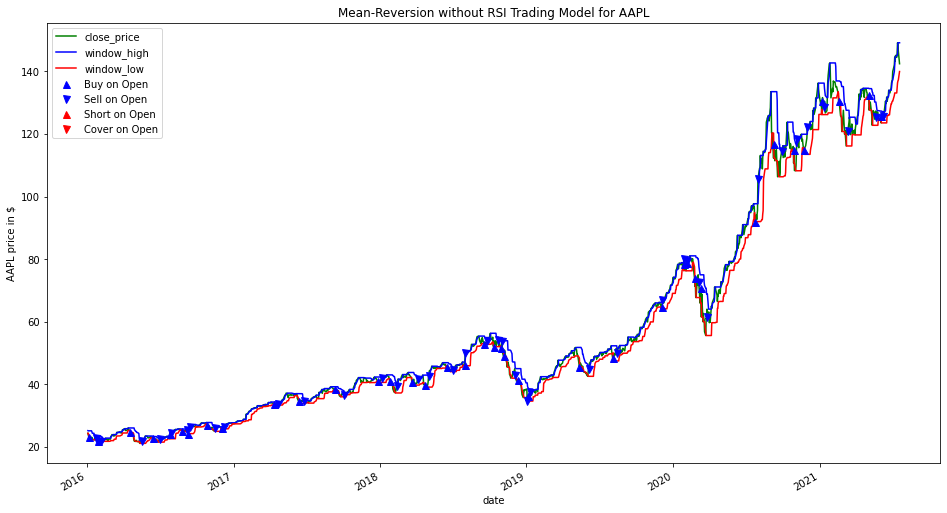

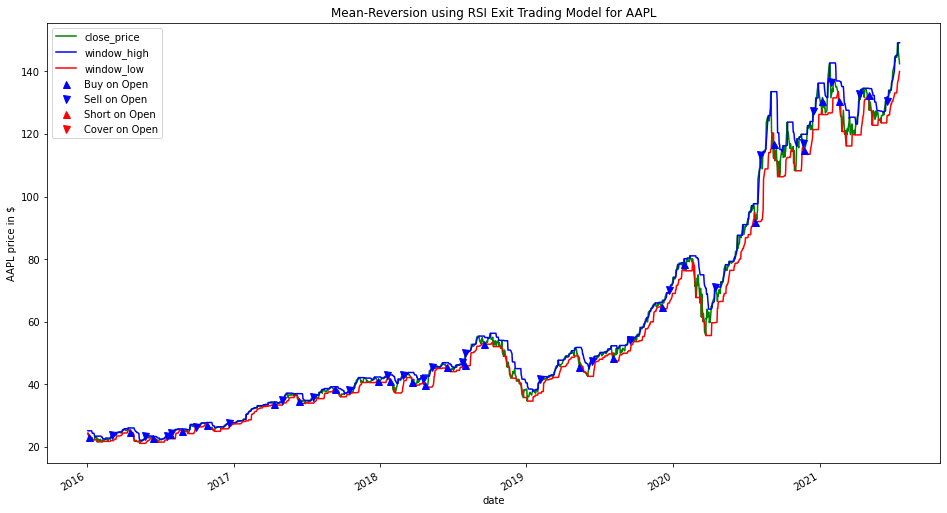

In [13]:
for symbol in stock_list:
    stock_signals_positions = {}
    stock_model_template = retrieve_stock_data(symbol)

    print('\nGenerating the trading signals for model #1...')
    tag_name = symbol + 'model1_signals'
    stock_signals_positions[tag_name] = populate_signals_model1(stock_model_template)

    print('\nGenerating the trading signals for model #2...')
    tag_name = symbol + 'model2_signals'
    stock_signals_positions[tag_name] = populate_signals_model2(stock_model_template)

    INITIAL_CAPITAL = stock_signals_positions[tag_name].at[stock_signals_positions[tag_name].index[0],'open_price']
    performance_values = evaluate_strategy_performance(symbol)
    performance_summary = performance_summary.append(performance_values, ignore_index=True)

In [14]:
print(performance_summary)

  Symbol  Model1_Return_VAL  Model1_Return_PCT  Model2_Return_VAL  Model2_Return_PCT  Buy_Hold_Return  BH_Return_PCT
0   AAPL              3.598          14.026197              45.97           179.2063          118.098     460.385155


In [15]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:12.943419
